In [1]:
from script import df_mobpro_brut, arr_marseille, arr_paris, arr_lyon, contours_comm, transport_dict, contours_comm, flux, plot_flux_gradient, plot_flux_gradient_zoom, coord_villes
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import seaborn as sns
import numpy as np
import matplotlib.colors as colors
from scipy.sparse import coo_matrix

/home/onyxia/work/statapp/script.py:19: DtypeWarning: Columns (1,1687,1688) have mixed types. Specify dtype option on import or set low_memory=False.
  df_dossier_complet_brut = pd.read_csv(file)
/home/onyxia/work/statapp/script.py:24: DtypeWarning: Columns (4,8) have mixed types. Specify dtype option on import or set low_memory=False.
  df_meta_dossier_complet_brut = pd.read_csv(file)
/home/onyxia/work/statapp/script.py:34: DtypeWarning: Columns (1,2,3,4,14,15,16,18,22,24,27,30,31,32) have mixed types. Specify dtype option on import or set low_memory=False.
  df_mobpro_brut = pd.read_csv(file)
/home/onyxia/work/statapp/script.py:100: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  contours_comm["centroid"] = contours_comm.geometry.centroid
/home/onyxia/work/statapp/script.py:109: UserWarning: Geometry is in a geographic CRS. Results from 'centroid'

antully: (46.89232199838103, 4.402852764409862)
le tremblay-omonville: (49.12081156432765, 0.9143802127565656)
vaux-lès-mouzon: (49.60389494206806, 5.136483053287144)
anchenoncourt-et-chazel: (47.8616809003776, 6.11534440434135)
culoz-béon: (45.85633732729717, 5.772905566192263)
domèvre-sur-avière: (48.22223470040439, 6.388423941842605)
bernoy-le-château: (49.32120314158208, 3.3070156677330558)
videcosville: (49.566672646936, -1.3714795795608266)
saint-agrève: (45.00542393638767, 4.413096930429594)
le bourg-d'oisans: (45.0340588974907, 6.032836629436181)


In [2]:
df_mobpro_brut.head()

,Unnamed: 0,COMMUNE,ARM,DCFLT,DCLT,AGEREVQ,CS1,DEROU,DIPL,EMPL,...,SEXE,STAT,STOCD,TP,TRANS,TYPL,TYPMR,VOIT,TRANS_LABEL,CS_LABEL
0,0,01001,ZZZZZ,99999,01001,40,2,Z,16,21,...,2,21,21,1,1,1,41,2,Pas de transport,"Artisans, commerçants, chef de société"
1,1,01001,ZZZZZ,99999,01001,45,5,Z,14,16,...,2,10,22,2,5,2,12,1,"Voiture, camion, fourgonnette",Employés
2,2,01001,ZZZZZ,99999,01001,20,2,Z,14,21,...,2,21,10,1,1,1,41,3,Pas de transport,"Artisans, commerçants, chef de société"
3,3,01001,ZZZZZ,99999,01001,55,2,Z,3,21,...,2,21,10,1,1,1,41,1,Pas de transport,"Artisans, commerçants, chef de société"
4,4,01001,ZZZZZ,99999,01001,55,2,Z,13,22,...,1,22,10,1,5,1,41,3,"Voiture, camion, fourgonnette","Artisans, commerçants, chef de société"


Ce que signifient chacune des en-têtes de colonnes :  
COMMUNE Département et commune du lieu de résidence  
ARM Arrondissement municipal de résidence (Paris, Lyon et Marseille)  
DCFLT Commune frontalière du lieu de travail  
DCLT Département, commune et arrondissement municipal (Paris, Lyon, Marseille) du lieu de travail  
AGEREVQ Âge quinquennal en années révolues  
CS1 Catégorie socioprofessionnelle en 8 postes  
DEROU Nombre de deux-roues à moteur du ménage (DOM)  
DIPL_15 Diplôme le plus élevé  
EMPL Condition d'emploi  
ILTUU Indicateur urbain du lieu de travail  
ILT Indicateur du lieu de travail  
IMMI Situation quant à l'immigration  
INATC Indicateur de nationalité condensé (Français/Étranger)  
INEEM Nombre d'élèves, étudiants ou stagiaires âgés de 14 ans ou plus du ménage  
INPOM Nombre de personnes actives ayant un emploi du ménage  
INPSM Nombre de personnes scolarisées du ménage  
IPONDI Poids de l'individu  
LPRM Lien à la personne de référence du ménage  
METRODOM Indicateur Métropole ou DOM du lieu de résidence  
MOCO Mode de cohabitation  
NA5 Activité économique regroupée en 5 postes  
NPERR Nombre de personnes du ménage (regroupé)  
REGION Région du lieu de résidence  
REGLT Région du lieu de travail  
SEXE Sexe  
STAT Statut professionnel  
STOCD Statut d'occupation détaillé du logement  
TP Temps de travail  
TRANS Mode de transport principal le plus souvent utilisé pour aller travailler  
TYPL Type de logement  
TYPMR Type de ménage regroupé (en 9 postes)  
VOIT Nombre de voitures du ménage  

TRANS_LABEL
Voiture, camion, fourgonnette    5345431
Transports en commun             1501858
Marche à pied ou rollers          537717
Pas de transport                  301139
Vélo (y compris électrique)       234421
Deux-roues motorisé               159396
Name: count, dtype: int64


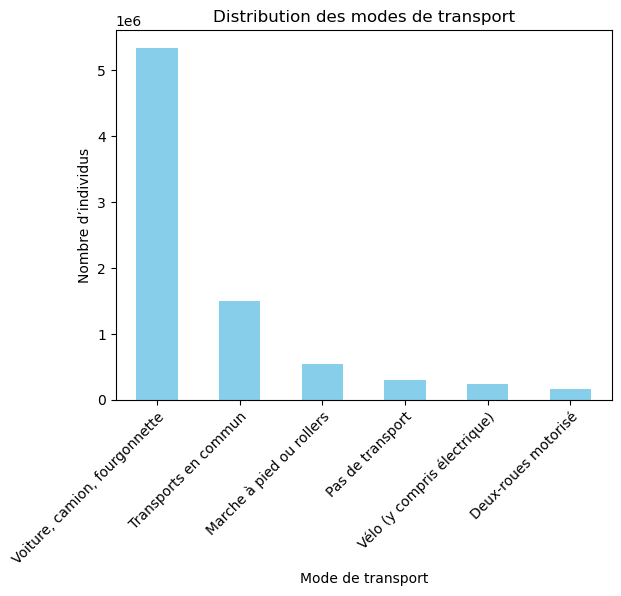

In [3]:
# Distribution des modes de transport utilisés pour aller travailler
transport_distribution = df_mobpro_brut['TRANS_LABEL'].value_counts()
print(transport_distribution)

# Visualisation
transport_distribution.plot(kind='bar', color='skyblue')
plt.xticks(rotation=45, ha='right', rotation_mode='anchor')
plt.title('Distribution des modes de transport')
plt.xlabel('Mode de transport')
plt.ylabel('Nombre d’individus')
plt.show()

TRANS_LABEL
Deux-roues motorisé              38.061997
Marche à pied ou rollers         38.992081
Pas de transport                 44.077751
Transports en commun             37.170818
Voiture, camion, fourgonnette    39.720284
Vélo (y compris électrique)      38.212106
Name: AGEREVQ, dtype: float64


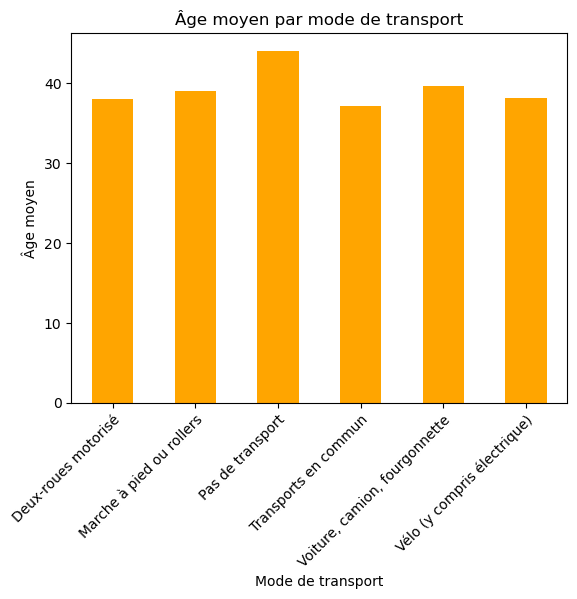

In [4]:
# Âge moyen par mode de transport
age_transport = df_mobpro_brut.groupby('TRANS_LABEL')['AGEREVQ'].mean()
print(age_transport)

# Visualisation
age_transport.plot(kind='bar', color='orange')
plt.xticks(rotation=45, ha='right', rotation_mode='anchor')
plt.title('Âge moyen par mode de transport')
plt.xlabel('Mode de transport')
plt.ylabel('Âge moyen')
plt.show()


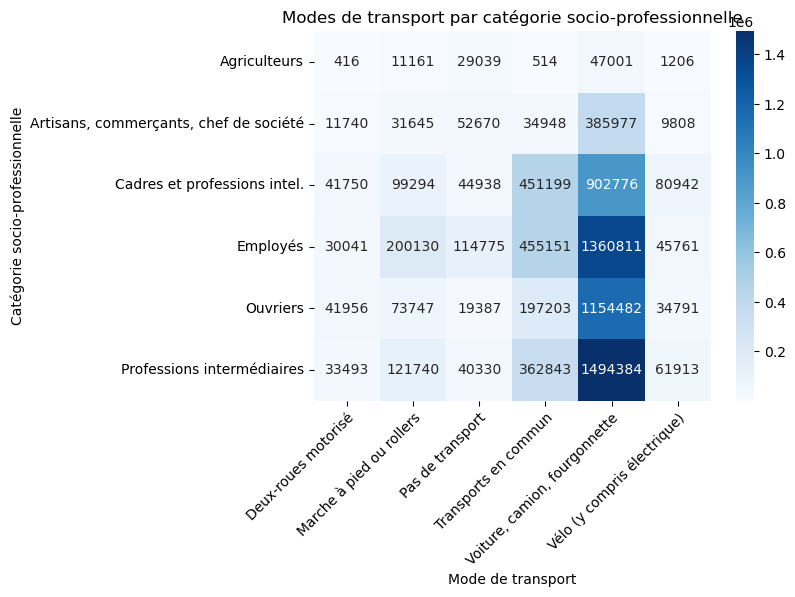

In [5]:
# Distribution des modes de transport par catégorie socio-professionnelle avec labels
cs1_transport = pd.crosstab(df_mobpro_brut['CS_LABEL'], df_mobpro_brut['TRANS_LABEL'])

# Heatmap
sns.heatmap(cs1_transport, annot=True, fmt='d', cmap='Blues')
plt.title('Modes de transport par catégorie socio-professionnelle')
plt.xlabel('Mode de transport')

# Inclinaison des labels avec alignement pour que l'extrémité pointe vers l'axe
plt.xticks(rotation=45, ha='right', rotation_mode='anchor')
plt.ylabel('Catégorie socio-professionnelle')
plt.show()


La fonction ci-dessous permet d'obtenir un premier tableau regroupant certaines informations par commune :
- Nombre de personnes du ménage (regroupé)
- Nombre de personnes scolarisées du ménage
- Nombre de personnes actives ayant un emploi du ménage
- Nombre d'élèves, étudiants ou stagiaires âgés de 14 ans ou plus du ménage
- Indicateur du lieu de travail
(1 Dans la commune de résidence actuelle
2 Dans une autre commune du département de résidence
3 Dans un autre département de la région de résidence
4 Hors de la région de résidence actuelle : en métropole
5 Hors de la région de résidence actuelle : dans un DOM
6 Hors de la région de résidence actuelle : dans une COM
7 A l'étranger)

In [6]:
# Conversion des colonnes en numérique
df_mobpro_brut['NPERR'] = pd.to_numeric(df_mobpro_brut['NPERR'], errors='coerce')
df_mobpro_brut['INPSM'] = pd.to_numeric(df_mobpro_brut['INPSM'], errors='coerce')
df_mobpro_brut['INPOM'] = pd.to_numeric(df_mobpro_brut['INPOM'], errors='coerce')
df_mobpro_brut['INEEM'] = pd.to_numeric(df_mobpro_brut['INEEM'], errors='coerce')

# Création des agrégations de base
mobpro_villes = df_mobpro_brut.groupby('COMMUNE').agg({
    'NPERR': 'sum',
    'INPSM': 'sum',
    'INPOM': 'sum',
    'INEEM': 'sum'})

# Créons d'abord un DataFrame temporaire pour chaque valeur d'ILT
for i in range(1, 8):
    # Grouper par COMMUNE et compter les occurrences où ILT == str(i)
    temp_count = df_mobpro_brut[df_mobpro_brut['ILT'] == i].groupby('COMMUNE').size()
    # Ajouter cette série au DataFrame principal
    mobpro_villes[f'ILT_{i}'] = temp_count

# Remplir les valeurs manquantes (NaN) par 0
mobpro_villes = mobpro_villes.fillna(0)

# Réinitialisation de l'index
mobpro_villes = mobpro_villes.reset_index()

In [7]:
mobpro_villes.head()

,COMMUNE,NPERR,INPSM,INPOM,INEEM,ILT_1,ILT_2,ILT_3,ILT_4,ILT_5,ILT_6,ILT_7
0,01001,275.0,65.0,194.0,13.0,11.0,58.0,20.0,1.0,0.0,0.0,0.0
1,01002,70.0,28.0,41.0,2.0,4.0,15.0,3.0,1.0,0.0,0.0,0.0
2,01004,6481.0,1787.0,3854.0,469.0,894.0,1105.0,422.0,33.0,0.0,0.0,5.0
3,01005,522.0,148.0,335.0,40.0,31.0,49.0,96.0,1.0,0.0,0.0,0.0
4,01006,35.0,4.0,31.0,0.0,1.0,7.0,5.0,0.0,0.0,0.0,0.0


On souhaite créer une matrice des flux pour avoir une vision générale des trajets domicile-travail quotidiens entre les villes. Pour chaque couple de ville, le nombre correspondant dans la matrice correspond au nombre de commute effectué de la ville 1 à la ville 2. 

On remarque que pour la variable "COMMUNE" (commune de résidence) on a uniquement 75056 pour Paris (idem pour Lyon et Marseille), tandis que pour la variable "DCLT" (commune de travail) on a un découpage en arrondissement avec les codes 75101,... pour Paris (idem pour Lyon et Marseille). Afin de pallier cette différence, on se cale sur l'échelle des arrondissements en remplaçant la valeur de "COMMUNE" par celle de "ARM" lorsque la ville en question est Paris, Marseille ou Lyon.

In [8]:
# Création d'une table croisée dynamique pour compter les déplacements
flux_tot = pd.crosstab(df_mobpro_brut['COMMUNE'], df_mobpro_brut['DCLT'])

# Conversion en DataFrame pour plus de clarté
flux_tot = pd.DataFrame(flux_tot)


# Pour voir les dimensions de la matrice
print("Dimensions de la matrice :", flux_tot.shape)

# Filtrer les données pour chaque groupe de transport
df_trans_45 = df_mobpro_brut[df_mobpro_brut['TRANS'].isin([4, 5])]
df_trans_6 = df_mobpro_brut[df_mobpro_brut['TRANS'] == 6]
df_trans_123 = df_mobpro_brut[df_mobpro_brut['TRANS'].isin([1, 2, 3])]

# Créer les matrices des flux pour chaque groupe
flux_rouge = pd.crosstab(df_trans_45['COMMUNE'], df_trans_45['DCLT'])
flux_jaune = pd.crosstab(df_trans_6['COMMUNE'], df_trans_6['DCLT'])
flux_vert = pd.crosstab(df_trans_123['COMMUNE'], df_trans_123['DCLT'])

# Convertir en DataFrame pour plus de clarté
flux_rouge = pd.DataFrame(flux_rouge)
flux_jaune = pd.DataFrame(flux_jaune)
flux_vert = pd.DataFrame(flux_vert)

# Afficher les dimensions des matrices
print("Dimensions de la matrice (TRANS = 4 ou 5) :", flux_rouge.shape)
print("Dimensions de la matrice (TRANS = 6) :", flux_jaune.shape)
print("Dimensions de la matrice (TRANS = 1, 2 ou 3) :", flux_vert.shape)


Dimensions de la matrice : (34881, 34078)
Dimensions de la matrice (TRANS = 4 ou 5) : (34817, 33012)
Dimensions de la matrice (TRANS = 6) : (17600, 10140)
Dimensions de la matrice (TRANS = 1, 2 ou 3) : (30250, 29908)


In [9]:
flux('78220', '75108', flux_jaune)

Nombre de personnes se déplaçant de 78220 vers 75108 : 2


In [10]:
flux_rouge

DCLT,01001,01002,01004,01005,01006,01007,01008,01009,01010,01011,...,98735,98736,98738,98753,98758,98807,98811,98815,98818,99999
COMMUNE,,,,,,,,,,,,,,,,,,,,,
01001,7,0,2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
01002,0,3,2,0,0,2,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
01004,0,0,585,0,0,6,1,0,0,0,...,0,0,0,0,0,0,0,0,0,5
01005,0,0,0,19,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
01006,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97420,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
97421,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
97422,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [11]:
# Pour les départs : somme sur l'axe des colonnes (chaque ligne = ville de départ)
df_flux_jaune_depart = flux_jaune.sum(axis=1).reset_index()
df_flux_jaune_depart.columns = ['COMMUNE', 'flux_depart']

# Pour les arrivées : somme sur l'axe des lignes (chaque colonne = ville d'arrivée)
df_flux_jaune_destination = flux_jaune.sum(axis=0).reset_index()
df_flux_jaune_destination.columns = ['DCLT', 'flux_destination']

print("Départ :", df_flux_jaune_depart.head())
print("Destination :", df_flux_jaune_destination.head())

df_flux_vert_depart = flux_vert.sum(axis=1).reset_index()
df_flux_vert_depart.columns = ['COMMUNE', 'flux_depart']

# Pour les arrivées : somme sur l'axe des lignes (chaque colonne = ville d'arrivée)
df_flux_vert_destination = flux_vert.sum(axis=0).reset_index()
df_flux_vert_destination.columns = ['DCLT', 'flux_destination']

print("Départ :", df_flux_vert_depart.head())
print("Destination :", df_flux_vert_destination.head())

df_flux_rouge_depart = flux_rouge.sum(axis=1).reset_index()
df_flux_rouge_depart.columns = ['COMMUNE', 'flux_depart']

# Pour les arrivées : somme sur l'axe des lignes (chaque colonne = ville d'arrivée)
df_flux_rouge_destination = flux_rouge.sum(axis=0).reset_index()
df_flux_rouge_destination.columns = ['DCLT', 'flux_destination']

print("Départ :", df_flux_rouge_depart.head())
print("Destination :", df_flux_rouge_destination.head())


Départ :   COMMUNE  flux_depart
0   01001            1
1   01002            1
2   01004          342
3   01005            4
4   01007           21
Destination :     DCLT  flux_destination
0  01004               116
1  01005                 2
2  01007                 2
3  01014                36
4  01023                 3
Départ :   COMMUNE  flux_depart
0   01001            4
1   01002            1
2   01004          297
3   01005           14
4   01007           10
Destination :     DCLT  flux_destination
0  01001                 4
1  01002                 1
2  01004               304
3  01005                12
4  01007                12
Départ :   COMMUNE  flux_depart
0   01001           85
1   01002           21
2   01004         1820
3   01005          159
4   01006           13
Destination :     DCLT  flux_destination
0  01001                11
1  01002                 4
2  01004              1644
3  01005                53
4  01006                 1


In [12]:
df_flux_jaune_depart_m = pd.merge(
        contours_comm[['INSEE_COM', 'NOM', 'POPULATION', 'INSEE_DEP', 'SIREN_EPCI', 'geometry']],
        df_flux_jaune_depart,
        left_on='INSEE_COM',
        right_on="COMMUNE",
        how='left')
df_flux_jaune_depart_m["flux_depart"] = df_flux_jaune_depart_m["flux_depart"].fillna(0).astype(int)

df_flux_vert_depart_m = pd.merge(
        contours_comm[['INSEE_COM', 'NOM', 'POPULATION', 'INSEE_DEP', 'SIREN_EPCI', 'geometry']],
        df_flux_vert_depart,
        left_on='INSEE_COM',
        right_on="COMMUNE",
        how='left')
df_flux_vert_depart_m["flux_depart"] = df_flux_vert_depart_m["flux_depart"].fillna(0).astype(int)

df_flux_rouge_depart_m = pd.merge(
        contours_comm[['INSEE_COM', 'NOM', 'POPULATION', 'INSEE_DEP', 'SIREN_EPCI', 'geometry']],
        df_flux_rouge_depart,
        left_on='INSEE_COM',
        right_on="COMMUNE",
        how='left')
df_flux_rouge_depart_m["flux_depart"] = df_flux_rouge_depart_m["flux_depart"].fillna(0).astype(int)


df_flux_jaune_destination_m = pd.merge(
        contours_comm[['INSEE_COM', 'NOM', 'POPULATION', 'INSEE_DEP', 'SIREN_EPCI', 'geometry']],
        df_flux_jaune_destination,
        left_on='INSEE_COM',
        right_on="DCLT",
        how='left')
df_flux_jaune_destination_m["flux_destination"] = df_flux_jaune_destination_m["flux_destination"].fillna(0).astype(int)

df_flux_vert_destination_m = pd.merge(
        contours_comm[['INSEE_COM', 'NOM', 'POPULATION', 'INSEE_DEP', 'SIREN_EPCI', 'geometry']],
        df_flux_vert_destination,
        left_on='INSEE_COM',
        right_on="DCLT",
        how='left')
df_flux_vert_destination_m["flux_destination"] = df_flux_vert_destination_m["flux_destination"].fillna(0).astype(int)

df_flux_rouge_destination_m = pd.merge(
        contours_comm[['INSEE_COM', 'NOM', 'POPULATION', 'INSEE_DEP', 'SIREN_EPCI', 'geometry']],
        df_flux_rouge_destination,
        left_on='INSEE_COM',
        right_on="DCLT",
        how='left')
df_flux_rouge_destination_m["flux_destination"] = df_flux_rouge_destination_m["flux_destination"].fillna(0).astype(int)

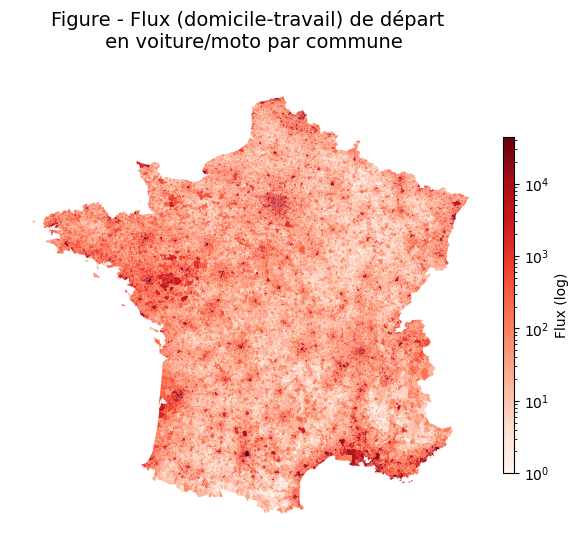

In [13]:
plot_flux_gradient(df_flux_rouge_depart_m, "rouge", "Figure - Flux (domicile-travail) de départ \n en voiture/moto par commune","flux_depart")

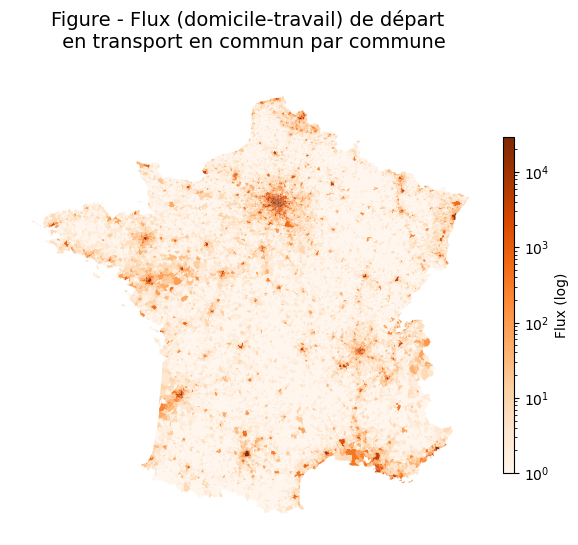

In [14]:
plot_flux_gradient(df_flux_jaune_depart_m, "jaune", "Figure - Flux (domicile-travail) de départ \n en transport en commun par commune","flux_depart")

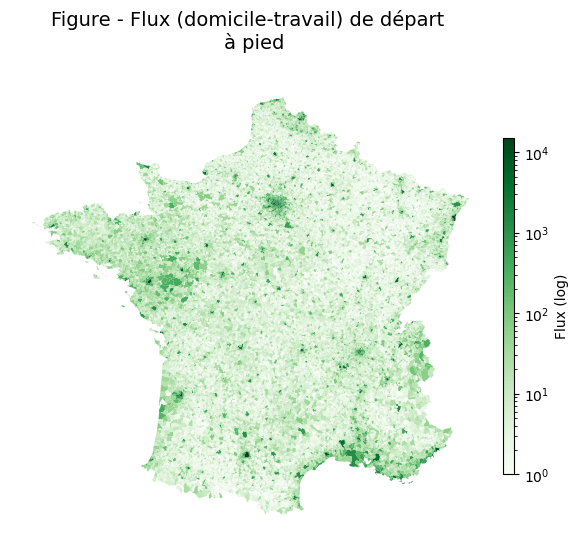

In [15]:
plot_flux_gradient(df_flux_vert_depart_m, "vert", "Figure - Flux (domicile-travail) de départ \n à pied","flux_depart")

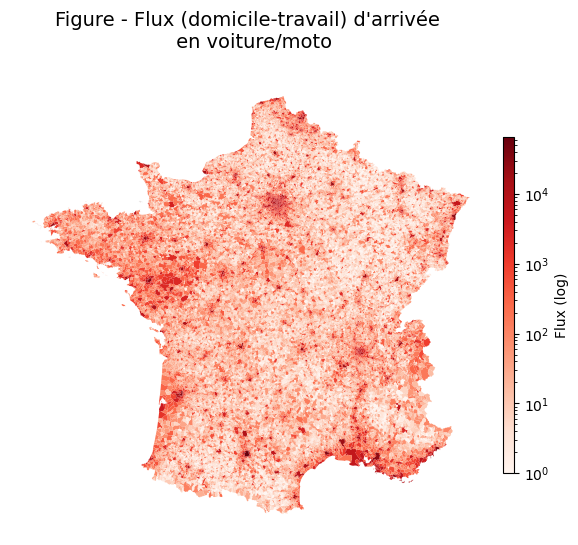

In [16]:
plot_flux_gradient(df_flux_rouge_destination_m, "rouge", "Figure - Flux (domicile-travail) d'arrivée \n en voiture/moto","flux_destination")

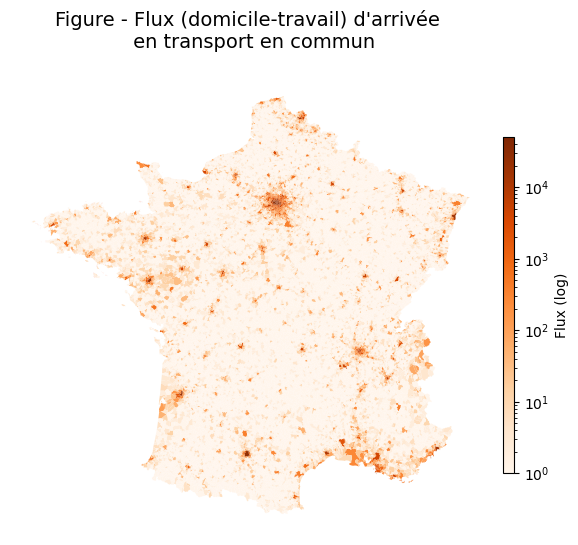

In [17]:
plot_flux_gradient(df_flux_jaune_destination_m, "jaune", "Figure - Flux (domicile-travail) d'arrivée \n en transport en commun","flux_destination")

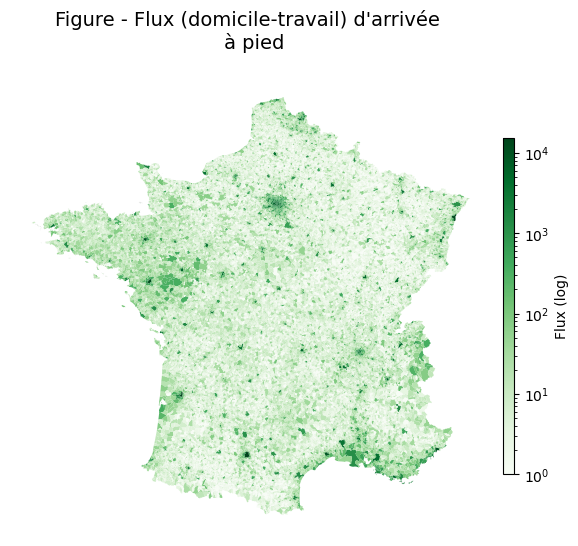

In [18]:
plot_flux_gradient(df_flux_vert_destination_m, "vert", "Figure - Flux (domicile-travail) d'arrivée \n à pied","flux_destination")

/opt/conda/lib/python3.12/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/home/onyxia/work/statapp/script.py:255: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroid = ville_cible.centroid.iloc[0]


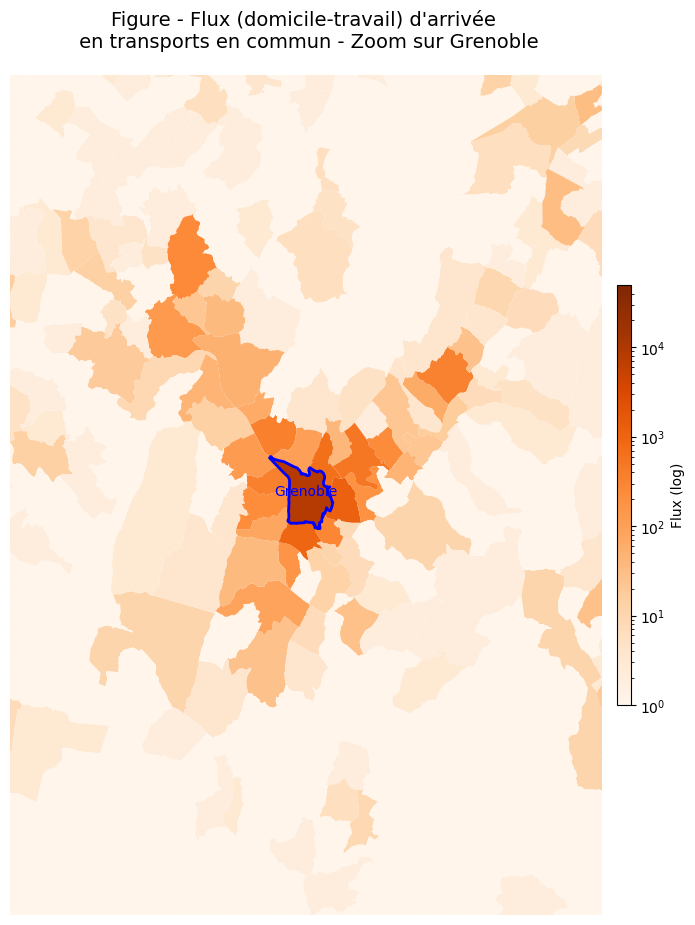

In [19]:
plot_flux_gradient_zoom(df_flux_jaune_destination_m, "jaune", "Figure - Flux (domicile-travail) d'arrivée \n en transports en commun","flux_destination", "grenoble")

In [20]:
df_flux_jaune_destination_m

,INSEE_COM,NOM,POPULATION,INSEE_DEP,SIREN_EPCI,geometry,DCLT,flux_destination
0,71010,Antully,869.0,71.0,200070530,"MULTIPOLYGON (((4.42739 46.92275, 4.42745 46.9...",NaN,0
1,27658,Le Tremblay-Omonville,369.0,27.0,242700607,"MULTIPOLYGON (((0.90536 49.10568, 0.90375 49.1...",NaN,0
2,08466,Vaux-lès-Mouzon,69.0,8.0,240800847,"MULTIPOLYGON (((5.1528 49.57652, 5.15277 49.57...",NaN,0
3,70017,Anchenoncourt-et-Chazel,240.0,70.0,200041879,"MULTIPOLYGON (((6.14568 47.84562, 6.14458 47.8...",NaN,0
4,01138,Culoz-Béon,3426.0,1.0,200040350,"MULTIPOLYGON (((5.80753 45.86064, 5.80739 45.8...",01138,12
...,...,...,...,...,...,...,...,...
34982,97603,Bandrele,10282.0,976.0,200060473,"MULTIPOLYGON (((45.16269 -12.87999, 45.16908 -...",NaN,0
34983,97605,Chiconi,8295.0,976.0,200059871,"MULTIPOLYGON (((45.12192 -12.83992, 45.1219 -1...",NaN,0
34984,97611,Mamoudzou,71437.0,976.0,200060457,"MULTIPOLYGON (((45.17305 -12.76405, 45.18155 -...",97611,53
34985,97614,Ouangani,10203.0,976.0,200059871,"MULTIPOLYGON (((45.15409 -12.87424, 45.14544 -...",NaN,0


In [ ]:
# Conversion en GeoDataFrame si nécessaire
if not isinstance(df_flux_jaune_destination_m, gpd.GeoDataFrame):
    df_flux_jaune_destination_m = gpd.GeoDataFrame(df_flux_jaune_destination_m, geometry='geometry')

# Agrégation des données par EPCI (sans la géométrie pour l'instant)
df_epci = df_flux_jaune_destination_m.groupby('SIREN_EPCI').agg({
    'flux_destination': 'sum',  # Somme des flux
    'NOM': list,                # Liste des noms de villes
    'INSEE_COM': list,          # Liste des codes INSEE
    'INSEE_DEP': list,          # Liste des départements
    'POPULATION': 'sum'         # Population totale par EPCI
}).reset_index()

# Fusion des polygones par EPCI avec GeoPandas (via dissolve)
gdf_epci = df_flux_jaune_destination_m.dissolve(by='SIREN_EPCI', aggfunc='sum')

# Joindre les informations non géométriques au GeoDataFrame final
gdf_epci = gdf_epci[['geometry']].merge(df_epci, on='SIREN_EPCI')

# Résultat final
print(gdf_epci.head())

  SIREN_EPCI                                           geometry  \
0  200000172  POLYGON ((6.45511 46.05427, 6.45502 46.05414, ...   
1  200000438  POLYGON ((-1.98129 47.47193, -1.98101 47.47168...   
2  200000545  POLYGON ((3.7003 48.471, 3.69984 48.47079, 3.6...   
3  200000628  POLYGON ((4.77447 44.21073, 4.77183 44.21077, ...   
4  200000800  POLYGON ((2.08755 47.58796, 2.08697 47.58708, ...   

   flux_destination                                                NOM  \
0                81  [Marignier, Contamine-sur-Arve, Glières-Val-de...   
1                29  [Crossac, Pontchâteau, Sainte-Anne-sur-Brivet,...   
2                51  [Crancey, Saint-Hilaire-sous-Romilly, Romilly-...   
3                46  [Lapalud, Mondragon, Mornas, Lamotte-du-Rhône,...   
4                45  [Chaumont-sur-Tharonne, Chaon, Vouzon, Nouan-l...   

                                           INSEE_COM  \
0  [74164, 74087, 74212, 74312, 74049, 74042, 74024]   
1  [44050, 44129, 44152, 44098, 44068, 4

In [ ]:
gdf_epci

,SIREN_EPCI,geometry,flux_destination,NOM,INSEE_COM,INSEE_DEP,POPULATION
0,200000172,"POLYGON ((6.45511 46.05427, 6.45502 46.05414, ...",81,"[Marignier, Contamine-sur-Arve, Glières-Val-de...","[74164, 74087, 74212, 74312, 74049, 74042, 74024]","[74.0, 74.0, 74.0, 74.0, 74.0, 74.0, 74.0]",27218.0
1,200000438,"POLYGON ((-1.98129 47.47193, -1.98101 47.47168...",29,"[Crossac, Pontchâteau, Sainte-Anne-sur-Brivet,...","[44050, 44129, 44152, 44098, 44068, 44196, 441...","[44.0, 44.0, 44.0, 44.0, 44.0, 44.0, 44.0, 44....",35917.0
2,200000545,"POLYGON ((3.7003 48.471, 3.69984 48.47079, 3.6...",51,"[Crancey, Saint-Hilaire-sous-Romilly, Romilly-...","[10114, 10341, 10323, 10164, 10220, 10280]","[10.0, 10.0, 10.0, 10.0, 10.0, 10.0]",18739.0
3,200000628,"POLYGON ((4.77447 44.21073, 4.77183 44.21077, ...",46,"[Lapalud, Mondragon, Mornas, Lamotte-du-Rhône,...","[84064, 84078, 84083, 84063, 84019]","[84.0, 84.0, 84.0, 84.0, 84.0]",24224.0
4,200000800,"POLYGON ((2.08755 47.58796, 2.08697 47.58708, ...",45,"[Chaumont-sur-Tharonne, Chaon, Vouzon, Nouan-l...","[41046, 41036, 41296, 41161, 41106, 41251]","[41.0, 41.0, 41.0, 41.0, 41.0, 41.0]",10437.0
...,...,...,...,...,...,...,...
1262,249740085,"POLYGON ((55.6798 -21.24004, 55.68159 -21.2402...",303,"[Le Tampon, Saint-Philippe, Saint-Joseph, Entr...","[97422, 97417, 97412, 97403]","[974.0, 974.0, 974.0, 974.0]",131368.0
1263,249740093,"POLYGON ((55.80221 -21.25183, 55.80168 -21.251...",415,"[Saint-André, Salazie, Bras-Panon, Saint-Benoî...","[97409, 97421, 97402, 97410, 97406, 97419]","[974.0, 974.0, 974.0, 974.0, 974.0, 974.0]",127537.0
1264,249740101,"MULTIPOLYGON (((55.41601 -21.12277, 55.416 -21...",1408,"[Le Port, Saint-Paul, La Possession, Saint-Leu...","[97407, 97415, 97408, 97413, 97423]","[974.0, 974.0, 974.0, 974.0, 974.0]",211983.0
1265,249740119,"POLYGON ((55.5739 -20.99355, 55.57387 -20.9936...",2899,"[Sainte-Marie, Sainte-Suzanne, Saint-Denis]","[97418, 97420, 97411]","[974.0, 974.0, 974.0]",211437.0


In [ ]:
def est_mono_departement(liste_departements):
    '''
    On vérifie si les EPCI regroupent forcément des villes qui appartiennent au même département (réponse = non pas systématiquement)
    return len(set(liste_departements)) == 1
    '''
    
# Appliquer la fonction à chaque ligne et créer une nouvelle colonne
gdf_epci['MONO_DEP'] = gdf_epci['INSEE_DEP'].apply(est_mono_departement)

/opt/conda/lib/python3.12/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


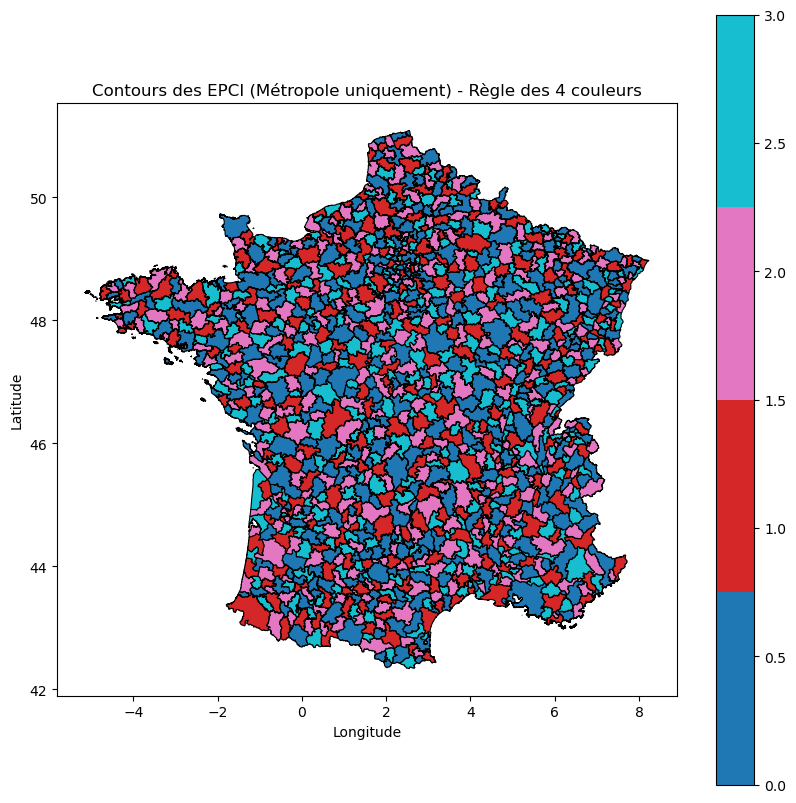

In [ ]:
# Filtrer pour ignorer les DOM-TOM en vérifiant que tous les départements associés sont en métropole
def est_metropole(liste_departements):
    """
    On ne souhaite afficher que la France Métropolitaine sinon on rencontre des soucis d'affichage
    """
    return all(dep < 970 for dep in liste_departements)
    
gdf_epci_metropole = gdf_epci[gdf_epci['INSEE_DEP'].apply(est_metropole)]

# Construire un graphe basé sur les frontières partagées
graph = nx.Graph()
for idx, row in gdf_epci_metropole.iterrows():
    graph.add_node(idx)
    for idx2, row2 in gdf_epci_metropole.iterrows():
        if idx != idx2 and row.geometry.touches(row2.geometry):
            graph.add_edge(idx, idx2)

# Algorithme de Welch-Powell pour la coloration du graphe
nodes_sorted = sorted(graph.nodes, key=lambda x: graph.degree[x], reverse=True)
color_map = {}
available_colors = list(range(4))  # 4 couleurs

for node in nodes_sorted:
    neighbor_colors = {color_map[neighbor] for neighbor in graph.neighbors(node) if neighbor in color_map}
    for color in available_colors:
        if color not in neighbor_colors:
            color_map[node] = color
            break
    else:
        color_map[node] = 0  # Sécurisation en cas de problème

# S'assurer que toutes les valeurs sont bien dans {0,1,2,3}
gdf_epci_metropole['color'] = gdf_epci_metropole.index.map(lambda x: color_map.get(x, 0))

# Tracer les contours des EPCI métropolitains avec la règle des 4 couleurs
fig, ax = plt.subplots(figsize=(10, 10))
cmap = plt.get_cmap("tab10", 4)
gdf_epci_metropole.plot(column='color', cmap=cmap, edgecolor='black', linewidth=0.8, ax=ax, legend=True)
plt.title("Contours des EPCI (Métropole uniquement) - Règle des 4 couleurs")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()